In [10]:
import pandas as pd
import numpy as np
import json, csv, re
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import nltk
import warnings

from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

pd.set_option('display.max_colwidth', 300)
sns.set_style('darkgrid')
tqdm.pandas()
%matplotlib inline

# Introdução

Classificar e reconhecer certos tipos de dados vem sendo exigida em diversas aplicações modernas e, principalmente, onde o Big Data é usado para tomar todos os tipos de decisões. As tarefas de classificação também permitem que pesquisadores consigam lidar com a grande quantidade de dados as quais têm acesso.

## Diferentes formas de classificar

Classificação é simplesmente agrupar as coisas de acordo com características e atributos (features) semelhantes. Dentro do Aprendizado de Máquina, ela não é diferente. A classificação faz parte de uma subárea chamada Aprendizado de Máquina Supervisionado, em que dados são agrupados com base em características predeterminadas.

Um problema de classificação requer que os dados sejam classificados em duas ou mais classes. Se o problema possui duas classes, ele é chamado de problema de classificação binário, e se possui mais de duas classes, é chamado de problema de classificação multi-class (multiclasse). Um exemplo de um problema de classificação binário seria você escolher comprar ou não um item da livraria (1 para “livro comprado” e 0 para “livro não comprado”).

O foco deste trabalho está em um variação da classificação multi-class: a classificação multi-label, em que um dado pode pertencer a várias classes diferentes.

## Classification problem

> A classification problem is when the output variable is a category, such as “red” or “blue” or “disease” and “no disease”. A classification model attempts to draw some conclusion from observed values. Given one or more inputs a classification model will try to predict the value of one or more outcomes.

## O que é multi-label classification?

> In machine learning, multi-label classification and the strongly related problem of multi-output classification are variants of the classification problem where multiple labels may be assigned to each instance. Multi-label classification is a generalization of multiclass classification, which is the single-label problem of categorizing instances into precisely one of more than two classes; in the multi-label problem there is no constraint on how many of the classes the instance can be assigned to.

### Exemplificando

| `X` | Binary | Multi-class | Multi-label |
|:--:|:--:|:--:|:--:|
| `X₁` | `t₁` | `t₂` | `[t₂,t₅]` |
| `X₂` | `t₂` | `t₃` | `[t₁,t₂,t₃,t₄]` |
| `X₃` | `t₁` | `t₄` | `[t₃]` |
| `X₄` | `t₂` | `t₁` | `[t₂,t₄]` |
| `X₅` | `t₁` | `t₃` | `[t₁t₃,t₄]` |

## Como resolver?

Podemos aplicar algoritmos de classificação tradicionais para resolver esse problema? Não, esses algoritmos esperam uma única classe para cada entrada, quando, em vez disso, temos várias classes.

Uma das maneiras de se resolver isso é construindo um sistema de recomendação. Uma abordagem simples é construindo um modelo que possa prever automaticamente classes.

### Referência

[https://insightlab.ufc.br/aprenda-a-estratificar-dados-multi-label-com-scikit-multilearn](https://insightlab.ufc.br/aprenda-a-estratificar-dados-multi-label-com-scikit-multilearn)

# Dataframe

Para exemplificar nosso metodo, vamos construir um modelo que possa prever o gênero de um filme usando apenas os detalhes do plot.

Nosso dataset é contrindo a partir dedois arquivos:

- movie.metadata.tsv: Metadados para 81.741 filmes.
- plot_summaries.txt: Resumos de plots de 42.306 filmes extraídos da Wikipedia em inglês. Cada linha contém o ID do filme da Wikipedia (que indexa em movie.metadata.tsv) seguido pelo resumo do plot.

In [11]:
%%time

def to_list(entry):
  return list(json.loads(entry).values())

meta = pd.read_csv("./data/movie.metadata.tsv", sep = '\t', header = None)
meta.columns = [
    'id_wiki', 'id_freebase',
    "title", 'release date',
    'box office revenue', 'runtime',
    'languages', 'countries', 'genres']

meta['languages'] = meta['languages'].apply(to_list)
meta['countries'] = meta['countries'].apply(to_list)
meta['genres'] = meta['genres'].apply(to_list)

meta['languages'] = meta['languages'].apply(lambda x: np.nan if len(x)==0 else x)
meta['countries'] = meta['countries'].apply(lambda x: np.nan if len(x)==0 else x)
meta['genres'] = meta['genres'].apply(lambda x: np.nan if len(x)==0 else x)
meta.head()

CPU times: user 1.51 s, sys: 46.1 ms, total: 1.56 s
Wall time: 1.59 s


,id_wiki,id_freebase,title,release date,box office revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure, Supernatural, Action, Space western]"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thriller]"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]


In [12]:
plots = []
with open("./data/plot_summaries.txt", 'r') as f:
  reader = csv.reader(f, dialect='excel-tab')
  for row in tqdm(reader): # tqdm, A Fast, Extensible Progress Bar for Python and CLI
      plots.append(row)

id_wiki = []
plot = []

for i in tqdm(plots):
  id_wiki.append(i[0])
  plot.append(i[1])

plots = pd.DataFrame({'id_wiki': id_wiki, 'plot': plot})
plots.head()

42303it [00:01, 26805.46it/s]
100%|██████████| 42303/42303 [00:00<00:00, 1044514.29it/s]


,id_wiki,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole..."
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e..."
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo..."
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r..."


In [13]:
meta['id_wiki'] = meta['id_wiki'].astype(str)
cols = ['id_wiki','title','plot','genres']

df = pd.merge(plots, meta[['id_wiki', 'title', 'genres']], on = 'id_wiki')
df.drop(df.loc[df['genres'].isna()].index, inplace=True)
df = df[cols]
df.head()

,id_wiki,title,plot,genres
0,23890098,Taxi Blues,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.","[Drama, World cinema]"
1,31186339,The Hunger Games,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...","[Action/Adventure, Science Fiction, Action, Drama]"
2,20663735,Narasimham,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...","[Musical, Action, Drama, Bollywood]"
3,2231378,The Lemon Drop Kid,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...","[Screwball comedy, Comedy]"
4,595909,A Cry in the Dark,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...","[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]"


In [14]:
genres_flat = pd.Series([item for sublist in df.genres for item in sublist])
df_genres = genres_flat.groupby(genres_flat).size().rename_axis('Genre').reset_index(name='Count')
df_genres.sort_values('Count', ascending=False, ignore_index=True, inplace=True)
print('Generos Total: {}'.format(df_genres.shape[0]))
#df_genres.head(10)

Generos Total: 363


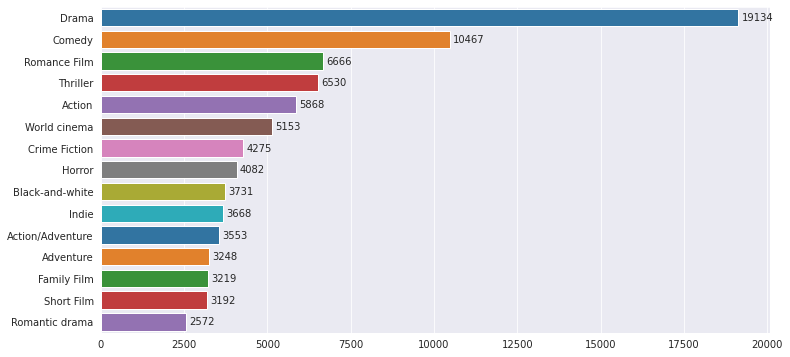

In [15]:
plt.figure(figsize=(12,6))
ax = sns.barplot(data=df_genres[:15], x='Count', y='Genre', palette='tab10')
ax.set(xlabel=None, ylabel=None)
ax.bar_label(ax.containers[0], padding=3)
plt.savefig('./plots/generos.eps', dpi=300, bbox_inches='tight', pad_inches=0.0)
plt.show()

# Pré-Processamento

## Normalização

> Normalization is the process of scaling individual samples to have unit norm.

In [16]:
def normaliza(doc):
    doc = re.sub("\'", "", doc)
    doc = re.sub("[^a-zA-Z]"," ", doc)
    doc = ' '.join(doc.split())
    doc = doc.lower()
    return doc

cols = ['id_wiki','title','plot','plot_pre','genres']
df['plot_pre'] = np.nan
df = df[cols]

%time df['plot_pre'] = df['plot'].progress_apply(normaliza)
df.head()

100%|██████████| 41793/41793 [00:07<00:00, 5951.28it/s]

CPU times: user 6.84 s, sys: 110 ms, total: 6.95 s
Wall time: 7.03 s


,id_wiki,title,plot,plot_pre,genres
0,23890098,Taxi Blues,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",shlykov a hard working taxi driver and lyosha a saxophonist develop a bizarre love hate relationship and despite their prejudices realize they arent so different after all,"[Drama, World cinema]"
1,31186339,The Hunger Games,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",the nation of panem consists of a wealthy capitol and twelve poorer districts as punishment for a past rebellion each district must provide a boy and girl between the ages of and selected by lottery for the annual hunger games the tributes must fight to the death in an arena the sole survivor is...,"[Action/Adventure, Science Fiction, Action, Drama]"
2,20663735,Narasimham,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",poovalli induchoodan is sentenced for six years prison life for murdering his classmate induchoodan the only son of justice maranchery karunakara menon was framed in the case by manapally madhavan nambiar and his crony dysp sankaranarayanan to take revenge on idealist judge menon who had earlier...,"[Musical, Action, Drama, Bollywood]"
3,2231378,The Lemon Drop Kid,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",the lemon drop kid a new york city swindler is illegally touting horses at a florida racetrack after several successful hustles the kid comes across a beautiful but gullible woman intending to bet a lot of money the kid convinces her to switch her bet employing a prefabricated con unfortunately ...,"[Screwball comedy, Comedy]"
4,595909,A Cry in the Dark,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",seventh day adventist church pastor michael chamberlain his wife lindy their two sons and their nine week old daughter azaria are on a camping holiday in the outback with the baby sleeping in their tent the family is enjoying a barbecue with their fellow campers when a cry is heard lindy returns...,"[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]"


## Stopwords

> Stop words are any word in a stop list (or stoplist or negative dictionary) which are filtered out (i.e. stopped) before or after processing of natural language data (text). There is no single universal list of stop words used by all natural language processing tools, nor any agreed upon rules for identifying stop words, and indeed not all tools even use such a list. Therefore, any group of words can be chosen as the stop words for a given purpose. The "general trend in [information retrieval] systems over time has been from standard use of quite large stop lists (200–300 terms) to very small stop lists (7–12 terms) to no stop list whatsoever"

In [17]:
stop_words = nltk.corpus.stopwords.words('english')

def remove_stopwords(doc):
    doc = doc.split()
    doc = [w for w in doc if not w in stop_words]
    doc = ' '.join(doc)
    return doc

%time df['plot_pre'] = df['plot_pre'].progress_apply(remove_stopwords)
df.head()

100%|██████████| 41793/41793 [00:31<00:00, 1319.26it/s]

CPU times: user 31.2 s, sys: 286 ms, total: 31.5 s
Wall time: 31.7 s


,id_wiki,title,plot,plot_pre,genres
0,23890098,Taxi Blues,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",shlykov hard working taxi driver lyosha saxophonist develop bizarre love hate relationship despite prejudices realize arent different,"[Drama, World cinema]"
1,31186339,The Hunger Games,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",nation panem consists wealthy capitol twelve poorer districts punishment past rebellion district must provide boy girl ages selected lottery annual hunger games tributes must fight death arena sole survivor rewarded fame wealth first reaping year old primrose everdeen chosen district older siste...,"[Action/Adventure, Science Fiction, Action, Drama]"
2,20663735,Narasimham,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",poovalli induchoodan sentenced six years prison life murdering classmate induchoodan son justice maranchery karunakara menon framed case manapally madhavan nambiar crony dysp sankaranarayanan take revenge idealist judge menon earlier given jail sentence manapally corruption case induchoodan achi...,"[Musical, Action, Drama, Bollywood]"
3,2231378,The Lemon Drop Kid,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",lemon drop kid new york city swindler illegally touting horses florida racetrack several successful hustles kid comes across beautiful gullible woman intending bet lot money kid convinces switch bet employing prefabricated con unfortunately kid woman belongs notorious gangster moose moran money ...,"[Screwball comedy, Comedy]"
4,595909,A Cry in the Dark,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",seventh day adventist church pastor michael chamberlain wife lindy two sons nine week old daughter azaria camping holiday outback baby sleeping tent family enjoying barbecue fellow campers cry heard lindy returns tent check azaria certain sees dingo something mouth running approaches discovers i...,"[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]"


words total: 152691


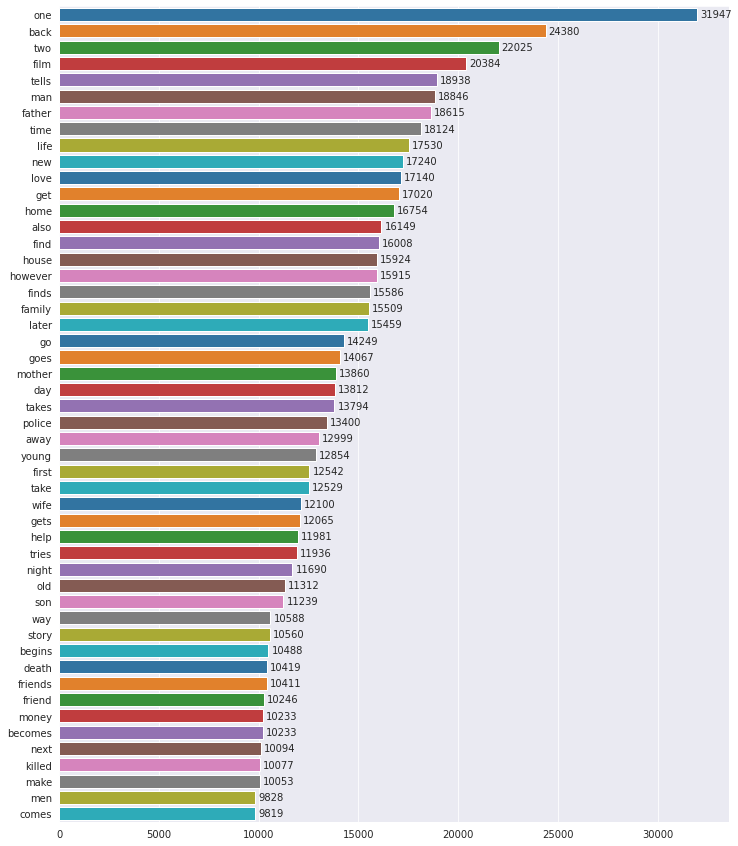

In [18]:
def words_freq(doc, terms=30): 
    li = ' '.join([text for text in doc])
    li = li.split() 
    freq = nltk.FreqDist(li) 
    df_words = pd.DataFrame({'word':list(freq.keys()), 'count':list(freq.values())})
    df_words.sort_values('count', ascending=False, ignore_index=True, inplace=True)
    print('words total: {}'.format(df_words.shape[0]))

    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=df_words[:terms], x='count', y='word', palette='tab10')
    ax.set(xlabel=None, ylabel=None)
    ax.bar_label(ax.containers[0], padding=3)
    plt.show()

words_freq(df['plot_pre'], 50)

In [19]:
df.shape

(41793, 5)

# Binary relevance

> is arguably the most intuitive solution for learning from multi-label examples. It works by decomposing the multi-label learning task into a number of independent binary learning tasks (one per class label).

## Implementação

| `X` | `y` |
|:--:|:--:|
| `X₁` | `[t₂,t₅]` |
| `X₂` | `[t₁,t₂,t₃,t₄]` |
| `X₃` | `[t₃]` |

`X` e `y` são os features e labels, respectivamente. Usando uma abordagem de relevância binária para transformar nossa variável alvo `y`. Extraimos primeiro os labels unicos no dataset:

    Labels unicos = [ t1, t2, t3, t4, t5 ]

Em seguida, subistituimos a variável alvo por várias outras variáveis, cada uma pertencendo aos labels unicos do dataset. Dado o exemplo acima, uma vez que existem 5 labels, haverá 5 novas variáveis alvos com valores 0 e 1, conforme mostrado abaixo:

| `X` | `t₁` | `t₂` | `t₃` | `t₄` | `t₅` |
|:--:|:--:|:--:|:--:|:--:|:--:|
| `X₁` | 1 | 0 | 0 | 0 | 1 |
| `X₂` | 1 | 1 | 1 | 1 | 0 |
| `X₃` | 0 | 0 | 1 | 0 | 0 |

In [20]:
mlb = MultiLabelBinarizer().fit(df['genres'])
y = mlb.transform(df['genres'])

# Feature extraction

> In machine learning, pattern recognition, and image processing, feature extraction starts from an initial set of measured data and builds derived values (features) intended to be informative and non-redundant, facilitating the subsequent learning and generalization steps, and in some cases leading to better human interpretations. Feature extraction is related to dimensionality reduction.

## TF-IDF

> TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

In [23]:
%%time
features = 10000
data = df['plot_pre']

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.8, max_features=features)
# 80-20 - 80% das amostras de dados no conjunto de treino e o resto no conjunto de validação
xtrain, xval, ytrain, yval = train_test_split(data, y, test_size=0.2, random_state=9)

xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

CPU times: user 47.6 s, sys: 2.01 s, total: 49.6 s
Wall time: 50.8 s


# Prediction Model

## Logistic regression

Treinar 363 modelos pode levar um tempo considerável. Dessa forma, construimos um modelo usando regressão logística, pois é rápido para treinar em poder computacional limitado.

> The purpose of logistic regression is to estimate the probabilities of events, including determining a relationship between features and the probabilities of particular outcomes.

In [13]:
warnings.filterwarnings(action='ignore')

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
%time clf.fit(xtrain_tfidf, ytrain)

CPU times: user 13min 26s, sys: 9min 46s, total: 23min 12s
Wall time: 7min 39s


OneVsRestClassifier(estimator=LogisticRegression())

In [14]:
joblib.dump(clf, './data/clf_object.pkl')

['./data/clf_object.pkl']

In [27]:
clf = joblib.load('./data/clf_object.pkl')

y_pred = clf.predict(xval_tfidf)
f1_score(yval, y_pred, average="micro")

0.31616576871026225

In [28]:
idx = 15
print('Array[{}] size: {}'.format(idx, len(y_pred[idx])))
print('{}'.format(mlb.inverse_transform(y_pred)[idx]))
y_pred[idx]

Array[15] size: 363
('Comedy', 'Drama', 'Romance Film')


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [37]:
t = 0.3
y_pred_prob = clf.predict_proba(xval_tfidf)
y_pred_new = (y_pred_prob >= t).astype(int)
f1_score(yval, y_pred_new, average="micro")

0.43752550395821427

# Pipeline

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import multilabel_confusion_matrix

In [34]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [40]:
CountVectorizer().get_params().keys()

dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'preprocessor', 'stop_words', 'strip_accents', 'token_pattern', 'tokenizer', 'vocabulary'])

In [35]:
lr = LogisticRegression()

pipeline = Pipeline(steps=[
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(lr))
])

param_grid = {
    'vect__max_features': [1000, 5000, 10000, 15000],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__max_df': [0.6, 0.8],
    'clf__estimator__C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
}

In [36]:
%%time
warnings.filterwarnings(action='ignore')
search = GridSearchCV(pipeline, param_grid, return_train_score=True, n_jobs=1)
search.fit(xtrain, ytrain)

CPU times: user 2h 46min 4s, sys: 1h 31min 43s, total: 4h 17min 47s
Wall time: 2h 19min 23s


GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        OneVsRestClassifier(estimator=LogisticRegression()))]),
             n_jobs=1,
             param_grid={'vect__max_df': [0.6, 0.8],
                         'vect__max_features': [5000, 10000]},
             return_train_score=True)

In [37]:
joblib.dump(search, './data/gs_object.pkl')

['./data/gs_object.pkl']

In [5]:
search = joblib.load("./data/gs_object.pkl")

print("Best parameter (CV score={}):".format(search.best_score_))
print(search.best_params_)

Best parameter (CV score=0.07028770446369503):
{'vect__max_df': 0.6, 'vect__max_features': 10000}


In [ ]:
#search.cv_results_

In [36]:
import sklearn.metrics as skm

confusion_mtrx = multilabel_confusion_matrix(yval, y_pred)
print(skm.classification_report(yval,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.00      0.00      0.00         1
           2       0.63      0.26      0.37      1154
           3       0.00      0.00      0.00        32
           4       0.00      0.00      0.00        82
           5       0.56      0.11      0.18       696
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        28
           8       0.72      0.16      0.26       639
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        19
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00        18
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00        23
          15       0.00      0.00      0.00        22
          16       0.00      0.00      0.00         8
          17       0.00    

/home/cecilio/Projetos/ufsj-Data-Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cecilio/Projetos/ufsj-Data-Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cecilio/Projetos/ufsj-Data-Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

In [38]:
print(skm.classification_report(yval,y_pred_new))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.00      0.00      0.00         1
           2       0.53      0.51      0.52      1154
           3       0.00      0.00      0.00        32
           4       0.00      0.00      0.00        82
           5       0.50      0.34      0.40       696
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        28
           8       0.55      0.34      0.42       639
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        19
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00        18
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00        23
          15       0.00      0.00      0.00        22
          16       0.00      0.00      0.00         8
          17       0.00    

/home/cecilio/Projetos/ufsj-Data-Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cecilio/Projetos/ufsj-Data-Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cecilio/Projetos/ufsj-Data-Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

# Análise

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


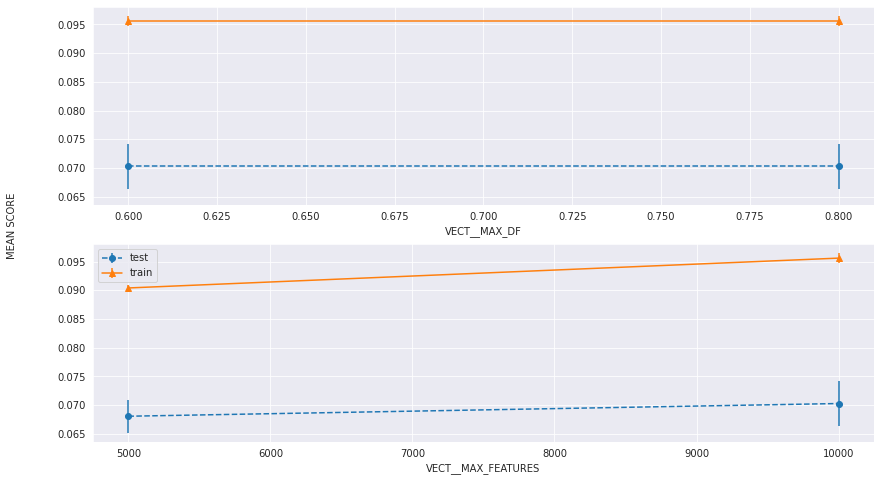

In [6]:
def plot_search_results(grid):

    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    masks = []
    masks_names = list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    #fig, ax = plt.subplots(1, len(params), sharex='none', sharey='all', figsize=(14,5))
    fig, ax = plt.subplots(2, 1, sharex='none', sharey='all', figsize=(14,8))
    #fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.savefig('./plots/results.eps', dpi=300, bbox_inches='tight', pad_inches=0.0)
    plt.show()

plot_search_results(search)

# Inferência

In [18]:
def infer_tags(q):
    q = normaliza(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return mlb.inverse_transform(q_pred)

In [31]:
n = 10
sample = xval.sample(n).index[:n]

df_results = pd.DataFrame({
    'title': df['title'][sample],
    'genres': df['genres'][sample],
    'predicted': ''
    })

for i, row in df_results.iterrows():
    row['predicted'] = infer_tags(xval[i])

df_results

,title,genres,predicted
484,Epitaph,"[Horror, World cinema]","[(Drama, Horror)]"
39194,The Secret of My Success,"[Romantic comedy, Romance Film, Comedy]","[(Comedy,)]"
6240,Kyo Kii... Main Jhuth Nahin Bolta,"[Fantasy, Drama, Comedy, World cinema]","[(Drama,)]"
37768,The Treasure of the Sierra Madre,"[Action/Adventure, Western, Drama, Adventure, Black-and-white]","[(Western,)]"
25136,Betrayal,"[Thriller, Drama]","[(Crime Fiction,)]"
24472,The Grudge 2,"[Japanese Movies, Horror, Supernatural]","[(Horror, Thriller)]"
2277,Mappillai,"[Romantic drama, Romance Film, Drama, World cinema]","[(Drama, Romance Film)]"
5633,Guilty of Romance,"[Drama, Japanese Movies, Horror, Film noir]","[(Drama, Romance Film, World cinema)]"
9710,Uuno Turhapuro muuttaa maalle,[Comedy film],[()]
25711,Thoondle,[Drama],[()]
